In [32]:
from model_based.transition_models import SimpleCatchEqui 
import matplotlib
import jax
import jax.numpy as jnp
import numpy as np
from distrax import Categorical
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'text.usetex': True, "font.family": "serif"})

In [33]:

def mock_all_states():
    states = jnp.zeros((45, 5, 50))
    for ball in range(45):
        for pad in range(5):
            state = jnp.zeros(50)
            state = state.at[ball].set(1.0)
            state = state.at[45 + pad].set(1.0)
            assert sum(state) == 2.0
            states = states.at[ball, pad, :].set(state)
    assert jnp.sum(states) == 45 * 5 * 2
    return states.reshape(-1, 50)

Is there a non random relationship between the location of the predictions of the two transition images

In [ ]:

NUM_STATES = 225
states = mock_all_states()
model = SimpleCatchEqui()
@jax.jit
def distance_distribution():
    modes_a = jnp.arange(50)
    modes_b = jnp.arange(50)
    xy = jax.vmap(lambda mode: divmod(mode, 5))
    modes_a_xy = xy(modes_a)
    modes_b_xy = xy(modes_b)
    def dist(x_1, y_1, x_2, y_2):
        return jnp.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2)
    broadcast_dist = jax.vmap(dist, in_axes=(None, None, 0, 0))
    dists = broadcast_dist(*modes_a_xy, *modes_b_xy)
    return dists.reshape(-1)


(array([0.20306924, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.69043545, 0.        , 0.        , 0.        , 0.58483944,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5685939 , 0.        , 0.95848687, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.38989296, 0.        ,
        0.44675235, 0.        , 0.74729484, 0.        , 0.        ,
        0.        , 0.60108498, 0.        , 0.        , 0.        ,
        0.32491159, 0.53610153, 0.        , 0.22743701, 0.        ,
        0.42238302, 0.        , 0.        , 0.        , 0.        ,
        0.51173327, 0.32491159, 0.        , 0.        , 0.24368251,
        0.        , 0.        , 0.09747348, 0.        , 0.16245579,
        0.16245501, 0.25992927, 0.        , 0.        , 0.19494601,
        0.0812279 , 0.        , 0.        , 0.12996401, 0.        ,
        0.        , 0.3167888 , 0.        , 0.21

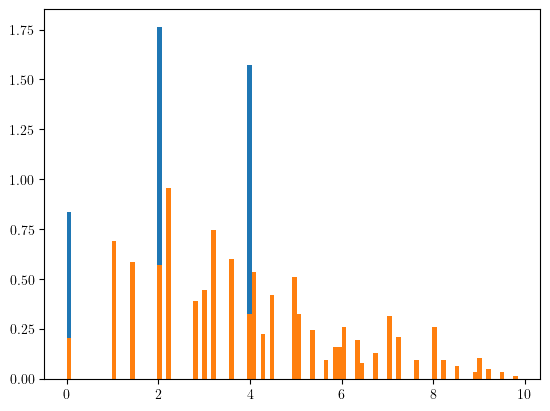

In [65]:


def location_corr(rng):
    model_params = model.init(rng, jnp.zeros((1, 50)), jnp.zeros((1,)))
    apply_fn = jax.jit(jax.vmap(model.apply, in_axes=(None, 0, 0)))
    zeros = apply_fn(model_params, states, jnp.zeros((NUM_STATES,1)))
    ones = apply_fn(model_params, states, jnp.ones((NUM_STATES,1)))
    twos = apply_fn(model_params, states, 2*jnp.ones((NUM_STATES,1)))
    all_state_action = jnp.concatenate((zeros,ones, twos), axis = 0)
        

    def logits_mode_dist(logits):
        def dist(pair_logits):
            assert pair_logits.shape == (50, 2)
            def _xy(_logits):
                x, y= divmod(Categorical(logits=_logits.reshape(-1)).mode(), 5)
                return x, y
            _x, _y= _xy(pair_logits[..., 0])
            inv_x, inv_y = _xy(pair_logits[..., 1])
            dx_= (_x- inv_x)**2
            dy_= (_y - inv_y)**2
            dist= jnp.sqrt(dx_ + dy_)
            return dist
        dist_fn = jax.vmap(dist)
        return dist_fn(logits)
    return logits_mode_dist(all_state_action)
key = jax.random.PRNGKey(10)
keys = jax.random.split(key, 10000)
dist_fn = jax.jit(jax.vmap(location_corr))
with jax.disable_jit(False):
    dists = dist_fn(keys)

plt.hist(dists.reshape(-1), density=True, bins=100)
plt.hist(distance_distribution().reshape(-1), bins=100, density=True)


In [78]:
model = SimpleCatchEqui()
states = mock_all_states()
def fp_corr(rng, state):
    # TODO make this so that it calculates the correlation per cell over all random initialization, and takes a average over the absolute value.
    def inner(rng):
        model_params = model.init(rng, jnp.zeros((1, 50)), jnp.zeros((1,)))
        apply_fn = jax.jit(jax.vmap(model.apply, in_axes=(None, 0, 0)))
        zeros = apply_fn(model_params, state, jnp.zeros((1,1)))
        ones = apply_fn(model_params, state, jnp.ones((1,1)))
        twos = apply_fn(model_params, state, 2*jnp.ones((1,1)))
        all_state_action = jnp.concatenate((zeros,ones, twos), axis = 0)
        return all_state_action
    keys = jax.random.split(rng, 1000)
    logits_sample = jax.vmap(inner)(keys).reshape(-1, 50, 2)



    def calculate_r_squared(logits_array):
        """Calculates the r^2 for each cell in the catch distributions"""
        means = logits_array.mean(axis = 0)
        assert means.shape == (50, 2)
        standard = logits_array - means[None, :, :]
        standard_x = (standard[:, :, 0]**2).mean(axis=0)
        standard_y = (standard[:, :, 1]**2).mean(axis=0)
        cov = (standard[:, :, 0] * standard[:, :, 1]).mean(axis=0)
        assert cov.shape == (50, ), cov.shape
        cov = cov/(jnp.sqrt(standard_x) * jnp.sqrt(standard_y))
        return cov.reshape(10, 5)
    return calculate_r_squared(logits_sample)

key = jax.random.PRNGKey(10)
corr_mat = fp_corr(key)

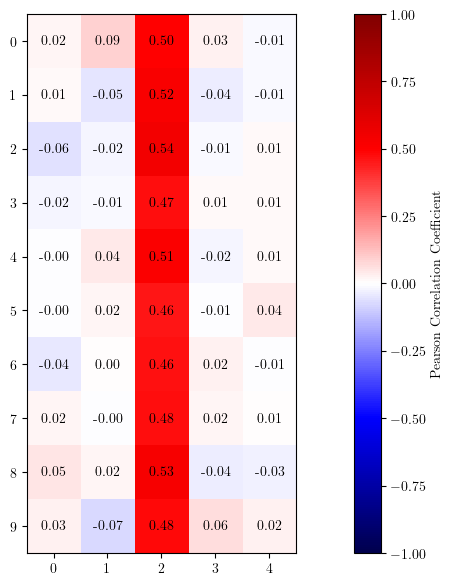

In [79]:
fig, ax = plt.subplots(figsize=(15, 7))
colors = matplotlib.colors
im = ax.imshow(corr_mat, vmin=-1, vmax=1, cmap="seismic")
ax.set_xticks(jnp.arange(0,5))
ax.set_yticks(jnp.arange(0,10))
for j in range(5):
    for i in range(10):
        text = ax.text(j, i, f"{corr_mat[i, j]:.2f}",
                       ha="center", va="center", color="black")
cbar = ax.figure.colorbar(im, )

cbar.set_label("Pearson Correlation Coefficient")

In [29]:
print(corr_ste)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [26]:
print(corr_mat)

[[0.5780132  0.60083073 0.5870634  0.60083073 0.5780132 ]
 [0.58564925 0.57915497 0.60297084 0.57915497 0.5856492 ]
 [0.5813029  0.58845377 0.5913502  0.58845377 0.5813029 ]
 [0.58979565 0.5788102  0.58465075 0.5788102  0.58979565]
 [0.59260637 0.59260076 0.58893615 0.5926008  0.59260637]
 [0.5818763  0.5805325  0.5932493  0.5805325  0.5818763 ]
 [0.59278333 0.5759226  0.60609215 0.5759226  0.59278333]
 [0.5849423  0.5916889  0.5949142  0.5916889  0.5849423 ]
 [0.57974064 0.58365464 0.59418267 0.58365464 0.57974064]
 [0.57969767 0.56498384 0.60318816 0.56498384 0.57969767]]
